In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir('..')
os.path.realpath(os.path.curdir)

'/pollard/home/bsmith/Projects/strain-corr'

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from lib.pandas_util import idxwhere, align_indexes, invert_mapping
import matplotlib as mpl
import lib.plot
import statsmodels as sm
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import subprocess
from tempfile import mkstemp
import time
import subprocess
from itertools import chain
from scipy.spatial.distance import pdist, squareform

In [4]:
import sfacts as sf

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# sns.set_context('talk')
# plt.rcParams['figure.dpi'] = 100
stemA = 'hmp2.a.r.proc'
centroid = 75
stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.fit-sfacts37-s80-seed0'
# stemB = 'filt-poly05-cvrg05.ss-g10000-block0-seed0.approx-clust2-thresh05-s95'

# Analysis Parameters

In [6]:
species_id = '102506'
# depth_ratio_bound = 3
# species_gene_corr_thresh = 0.99
# n_species_genes = 2000
species_gene_corr_thresh = 0.98

# Prepare Data

## Taxonomy

In [7]:
species_taxonomy = pd.read_table('ref/gtpro/species_taxonomy_ext.tsv', names=['genome_id', 'species_id', 'taxonomy_string']).assign(species_id=lambda x: x.species_id.astype(str)).set_index('species_id')[['taxonomy_string']].assign(taxonomy_split=lambda x: x.taxonomy_string.str.split(';'))

for level_name, level_number in [('p__', 1), ('c__', 2), ('o__', 3), ('f__', 4), ('g__', 5), ('s__', 6)]:
    species_taxonomy = species_taxonomy.assign(**{level_name: species_taxonomy.taxonomy_split.apply(lambda x: x[level_number])}) 
species_taxonomy = species_taxonomy.drop(columns=['taxonomy_split'])

species_taxonomy.loc[species_id]

taxonomy_string    d__Bacteria;p__Proteobacteria;c__Gammaproteoba...
p__                                                p__Proteobacteria
c__                                           c__Gammaproteobacteria
o__                                              o__Enterobacterales
f__                                            f__Enterobacteriaceae
g__                                                   g__Escherichia
s__                                                              s__
Name: 102506, dtype: object

In [8]:
midasdb_genomes = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv')

In [9]:
midasdb_genomes.Species_rep.value_counts()

GUT_GENOME144544    8288
GUT_GENOME143712    7507
GUT_GENOME096083    5983
GUT_GENOME143505    5750
GUT_GENOME095971    5042
                    ... 
GUT_GENOME141102       1
GUT_GENOME141101       1
GUT_GENOME141041       1
GUT_GENOME006201       1
GUT_GENOME286625       1
Name: Species_rep, Length: 4644, dtype: int64

## Species

In [10]:
all_species_depth = pd.read_table(f'data/{stemA}.gtpro.species_depth.tsv', index_col=['sample', 'species_id']).squeeze().unstack('species_id', fill_value=0).rename(str, axis='columns')
species_rabund = all_species_depth.divide(all_species_depth.sum(1), axis=0)

In [11]:
gtpro_species_depth = pd.read_table(f'data/sp-{species_id}.{stemA}.gtpro.species_depth.tsv', dtype=dict(sample=str, species_id=str, depth=float), index_col=['sample', 'species_id']).squeeze().unstack('species_id')

In [12]:
species_depth = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_depth.tsv', names=['sample', 'depth'], index_col='sample').squeeze()

In [13]:
gene_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.depth.nc').sel(sample=species_depth.index)

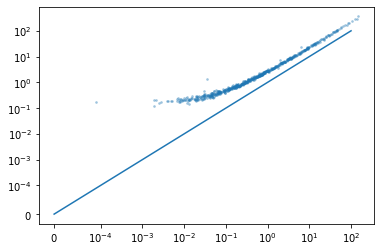

In [14]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=d, s=3, alpha=0.3)
plt.plot([0, 1e2], [0, 1e2])
plt.yscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-4)

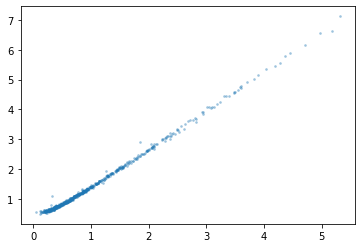

In [15]:
d = pd.DataFrame(dict(gtpro=gtpro_species_depth[species_id], midas=species_depth))

plt.scatter('gtpro', 'midas', data=np.cbrt(d), s=3, alpha=0.3)
# plt.plot([0, 1e2], [0, 1e2])
# plt.yscale('symlog', linthresh=1e-4)
# plt.xscale('symlog', linthresh=1e-4)

In [16]:
species_corr = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.species_correlation.tsv', names=['sample', 'correlation'], index_col='sample').squeeze()

## Metadata

In [17]:
mgen = pd.read_table('meta/hmp2/mgen.tsv', index_col='library_id')
preparation = pd.read_table('meta/hmp2/preparation.tsv', index_col='preparation_id')
stool = pd.read_table('meta/hmp2/stool.tsv', index_col='stool_id')
subject = pd.read_table('meta/hmp2/subject.tsv', index_col='subject_id')

sample_meta = mgen.join(preparation, on='preparation_id', rsuffix='_').join(stool, on='stool_id').join(subject, on='subject_id').loc[all_species_depth.index]

In [18]:
len(sample_meta.stool_id.unique()), len(sample_meta.subject_id.unique())

(1305, 106)

## Strains

In [19]:
fit = sf.World.load(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.world.nc'
).drop_low_abundance_strains(0.05)
print(fit.sizes)

np.random.seed(0)
position_ss = fit.random_sample(position=min(fit.sizes['position'], 1000)).position

Frozen({'strain': 136, 'position': 10000, 'sample': 624, 'allele': 2})


In [20]:
strain_corr = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack(fill_value=0)
# strain_corr = strain_by_species_corr.sel(species_id=species_id).to_series().unstack('strain')
strain_depth = pd.read_table(
    f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_depth_ratio.tsv',
    index_col=['gene_id', 'strain']
).squeeze().unstack()
strain_corr, strain_depth = align_indexes(*align_indexes(strain_corr, strain_depth), axis="columns")

In [21]:
sample_to_strain = (
    (fit.community.data > 0.95)
    .to_series()
    .unstack()
    .apply(idxwhere, axis=1)
    [lambda x: x.apply(bool)]
    .str[0]
    .rename('strain')
)
    
strain_to_sample_list = (
    sample_to_strain
    .rename('strain_id')
    .reset_index()
    .groupby('strain_id')
    .apply(lambda x: x['sample'].to_list())
)
strain_to_sample_list.apply(len).sort_values(ascending=False).head()

strain_id
8     78
34    16
22    15
7     15
36    11
dtype: int64

In [22]:
# species_gene_corr_thresh = species_corr.sort_values(ascending=False).head(n_species_genes + 1).min()
species_gene_list = idxwhere(species_corr.loc[strain_corr.index] > species_gene_corr_thresh)
print(len(species_gene_list))

2407


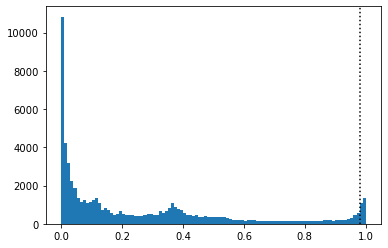

In [23]:
# strain_thresh = pd.read_table(
#     f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_correlation_threshold.tsv',
#     names=['strain_id', 'threshold'],
#     index_col='strain_id',
# ).loc[strain_corr.columns]
plt.hist(species_corr, bins=np.linspace(0, 1, num=101))
plt.axvline(species_gene_corr_thresh, linestyle=':', color='k')

In [24]:
strain_frac = pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.comm.tsv', index_col=['sample', 'strain']).squeeze().unstack(fill_value=0)

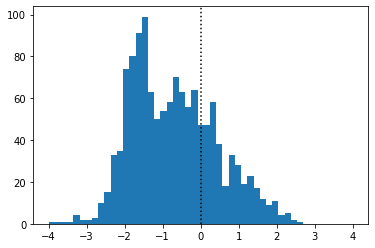

In [25]:
plt.hist(np.log10(species_depth[species_depth > 0]), bins=np.linspace(-4, 4))
plt.axvline(np.log10(1.0), linestyle=':', color='k')

## MIDAS Genes, COGs, COG categories

In [26]:
gene_cluster = pd.read_table(
    f'ref_temp/midasdb_uhgg/pangenomes/{species_id}/cluster_info.txt'
).set_index('centroid_99', drop=False).rename_axis(index='gene_id')
gene_annotation = pd.read_table(
    f'ref_temp/midasdb_uhgg.sp-{species_id}.gene{centroid}_annotations.tsv',
    names=['locus_tag', 'ftype', 'length_bp', 'gene', 'EC_number', 'COG', 'product'],
    index_col='locus_tag',
).rename(columns=str.lower)

gene_meta = gene_cluster.loc[gene_cluster[f'centroid_{centroid}'].unique()].join(gene_annotation)

In [27]:
gene_cluster

,centroid_99,centroid_95,centroid_90,centroid_85,centroid_80,centroid_75,centroid_99_length,marker_id
gene_id,,,,,,,,
UHGG264295_02694,UHGG264295_02694,UHGG000489_01994,UHGG145038_05014,UHGG145038_05014,UHGG140813_01958,UHGG140813_01958,1575,NaN
UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,UHGG055235_02557,798,NaN
UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,UHGG096120_03929,996,NaN
UHGG000026_00004,UHGG000026_00004,UHGG000026_00004,UHGG030504_01798,UHGG144120_04301,UHGG144120_04301,UHGG144120_04301,216,NaN
UHGG000026_00005,UHGG000026_00005,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,UHGG001456_04534,570,NaN
...,...,...,...,...,...,...,...,...
UHGG286636_03296,UHGG286636_03296,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,UHGG145316_04861,303,NaN
UHGG286636_03300,UHGG286636_03300,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,UHGG143784_00990,522,NaN
UHGG286636_03336,UHGG286636_03336,UHGG286636_03336,UHGG188012_03408,UHGG033419_01830,UHGG033419_01830,UHGG033419_01830,411,NaN


In [28]:
_cog_meta = pd.read_table(
    'ref/cog-20.meta.tsv',
    names=['cog', 'categories', 'description', 'gene', 'pathway', '_1', '_2'],
    index_col=['cog']
)
cog_meta = _cog_meta.drop(columns=['categories', '_1', '_2'])
cog_x_category = _cog_meta.categories.apply(tuple).apply(pd.Series).unstack().to_frame(name='category').reset_index()[['cog', 'category']].dropna()

In [29]:
cog_category = pd.read_table('ref/cog-20.categories.tsv', names=['category', 'description'], index_col='category')

## Genes

In [30]:
sample_depth = xr.load_dataarray(f'data_temp/sp-{species_id}.{stemA}.midas_gene{centroid}.depth.nc')

## References

In [31]:
reference_meta = pd.read_table('ref_temp/uhgg_genomes_all_4644.tsv', index_col='Genome').rename_axis(index='genome_id')[lambda x: x.MGnify_accession == 'MGYG-HGUT-' + species_id[1:]].rename(lambda s: 'UHGG' + s[10:])
reference_meta.head()

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,Species_rep,MGnify_accession,Lineage,Continent
genome_id,,,,,,,,,,,
UHGG000026,Isolate,5095388,44,245104,50.56,99.72,0.08,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000027,Isolate,4998207,106,103519,50.65,99.03,0.30,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000036,Isolate,4978086,124,99332,50.65,99.27,0.35,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe
UHGG000309,Isolate,4682102,42,653581,50.65,99.97,0.93,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,North America
UHGG000316,Isolate,5046484,66,244235,50.51,99.67,0.04,GUT_GENOME144544,MGYG-HGUT-02506,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Europe


In [32]:
reference_gene = xr.load_dataarray(f'data_temp/sp-{species_id}.midas_gene{centroid}.reference_copy_number.nc')
reference_gene = pd.DataFrame(reference_gene.T.values, index=reference_gene.gene_id, columns=reference_gene.genome_id)

In [33]:
isolate_gene = reference_gene[idxwhere(reference_meta.Genome_type == 'Isolate')]

# Select strains, genes

## QC Strains

In [1078]:
strain_thresholds = (
    pd.read_table(f'data_temp/sp-{species_id}.{stemA}.gtpro.{stemB}.midas_gene{centroid}.strain_gene_threshold.tsv', index_col='strain')
    .rename(columns=dict(
        correlation_strict='corr_threshold_strict',
        correlation_moderate='corr_threshold_moderate',
        correlation_lenient='corr_threshold_lenient',
        depth_high='depth_thresh_high',
        depth_low='depth_thresh_low',
    ))
)

In [1080]:
_strain_meta = (
    strain_thresholds
    .join(fit.genotype.entropy().to_series().rename('genotype_entropy'))
    .join(fit.metagenotype.entropy().to_series().rename('metagenotype_entropy').groupby(sample_to_strain).mean().rename(int))
    .join(strain_to_sample_list.apply(len).rename('num_samples'))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).std().rename('depth_stdev').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).max().rename('depth_max').rename(int))
    .join(species_depth.apply(np.cbrt).groupby(sample_to_strain).sum().rename('depth_sum').rename(int))
    .assign(power_index=lambda x: (x.depth_stdev * np.sqrt(x.num_samples)).fillna(0))
)
strain_meta = _strain_meta
high_power_strain_list = idxwhere((strain_meta.power_index > 1.0) & (strain_meta.metagenotype_entropy < 0.05))
print(len(high_power_strain_list))
highest_power_strain_list = strain_meta.sort_values('power_index', ascending=False).head(3).index
strain_meta.sort_values('num_samples', ascending=False)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


18


,corr_threshold_strict,corr_threshold_moderate,corr_threshold_lenient,depth_thresh_low,depth_thresh_high,genotype_entropy,metagenotype_entropy,num_samples,depth_stdev,depth_max,depth_sum,power_index
strain,,,,,,,,,,,,
8,0.992354,0.989579,0.979469,0.237956,2.166650,0.058286,0.002158,78,1.009860,5.898217,102.242937,8.918840
34,0.914044,0.875823,0.779164,0.184311,2.443396,0.124003,0.001017,16,0.554255,2.401835,18.082262,2.217020
22,0.960461,0.939766,0.863620,0.195381,2.377380,0.095271,0.001336,15,0.648283,3.000180,17.581897,2.510789
7,0.901547,0.861141,0.716327,0.205682,2.568609,0.137511,0.003036,15,0.427315,2.451602,17.493144,1.654983
36,0.993577,0.991140,0.982890,0.256457,2.461352,0.057694,0.001486,11,1.265402,7.119434,42.458982,4.196863
3,0.947465,0.927903,0.871473,0.215440,2.322934,0.175274,0.015242,10,0.883479,2.831254,16.076713,2.793805
85,0.912641,0.870551,0.761157,0.181206,2.434600,0.144607,0.010447,10,0.546210,2.250560,13.783452,1.727268
39,0.695074,0.605222,0.421250,0.130394,3.339473,0.186887,0.000937,10,0.343287,1.643140,10.177190,1.085569
27,0.986871,0.980251,0.934161,0.220824,2.135429,0.127603,0.017579,9,1.609350,4.542866,20.544801,4.828049


In [1081]:
high_power_strain_palette = lib.plot.construct_ordered_palette(high_power_strain_list, mpl.cm.Spectral)

## Select Genes

In [1099]:
strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
low_corr =  strain_corr < strain_meta.corr_threshold_lenient
depth_hit = (strain_depth < strain_meta.depth_thresh_high) & (strain_depth > strain_meta.depth_thresh_low)
low_depth = (strain_depth < strain_meta.depth_thresh_low)
high_depth = (strain_depth > strain_meta.depth_thresh_high)
high_confidence_hit = depth_hit & strict_corr_hit
maybe_hit = depth_hit & lenient_corr_hit
low_depth_hit = low_depth & strict_corr_hit
high_depth_hit = high_depth & strict_corr_hit
ambiguous_hit = depth_hit ^ strict_corr_hit
high_confidence_not_hit = low_depth & low_corr

/tmp/bsmith/ipykernel_99976/492059110.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  strict_corr_hit = strain_corr > strain_meta.corr_threshold_strict
/tmp/bsmith/ipykernel_99976/492059110.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  lenient_corr_hit = strain_corr > strain_meta.corr_threshold_lenient
/tmp/bsmith/ipykernel_99976/492059110.py:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  low_corr =  strain_corr < strain_meta.corr_threshold_lenient
/tmp/bsmith/ipyk

In [1084]:
strain_meta.loc[high_power_strain_list]

,corr_threshold_strict,corr_threshold_moderate,corr_threshold_lenient,depth_thresh_low,depth_thresh_high,genotype_entropy,metagenotype_entropy,num_samples,depth_stdev,depth_max,depth_sum,power_index
strain,,,,,,,,,,,,
1,0.988872,0.983980,0.970033,0.229846,2.088094,0.074376,0.001964,6,0.854029,4.653019,19.959178,2.091935
3,0.947465,0.927903,0.871473,0.215440,2.322934,0.175274,0.015242,10,0.883479,2.831254,16.076713,2.793805
6,0.999967,0.999920,0.999493,0.224570,2.250087,0.132875,0.040591,2,3.407103,5.452232,6.086092,4.818371
7,0.901547,0.861141,0.716327,0.205682,2.568609,0.137511,0.003036,15,0.427315,2.451602,17.493144,1.654983
8,0.992354,0.989579,0.979469,0.237956,2.166650,0.058286,0.002158,78,1.009860,5.898217,102.242937,8.918840
10,0.999588,0.999392,0.998669,0.241652,2.054020,0.059422,0.003928,5,2.146850,6.624767,14.143690,4.800502
16,0.993290,0.987075,0.940810,0.178660,2.300780,0.169217,0.027910,5,1.031924,3.160628,6.886765,2.307453
22,0.960461,0.939766,0.863620,0.195381,2.377380,0.095271,0.001336,15,0.648283,3.000180,17.581897,2.510789
27,0.986871,0.980251,0.934161,0.220824,2.135429,0.127603,0.017579,9,1.609350,4.542866,20.544801,4.828049


In [1144]:
high_confidence_hit[high_power_strain_list].sum()

strain
1     4387
3     3613
6     4795
7     4843
8     4009
10    3890
16    4684
22    4773
27    3217
34    4289
36    3866
39    5050
53    4306
54    4754
57    5033
67    4274
81    5058
85    4559
dtype: int64

In [40]:
samples_with_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() > 0.5)
samples_without_high_power_strains = idxwhere(fit.community.data.sel(strain=high_power_strain_list).sum("strain").to_series() < 0.5)
len(samples_with_high_power_strains), len(samples_without_high_power_strains)

(424, 200)

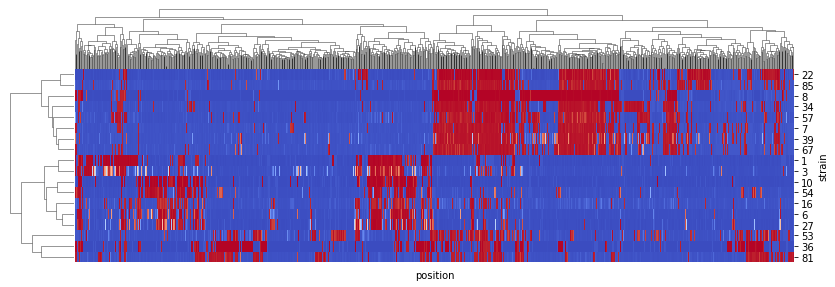

In [41]:
sf.plot.plot_genotype(
    fit.sel(strain=high_power_strain_list, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage("position"),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
)

/include/StrainFacts/sfacts/math.py:28: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = (weight * dist).sum() / weight.sum()


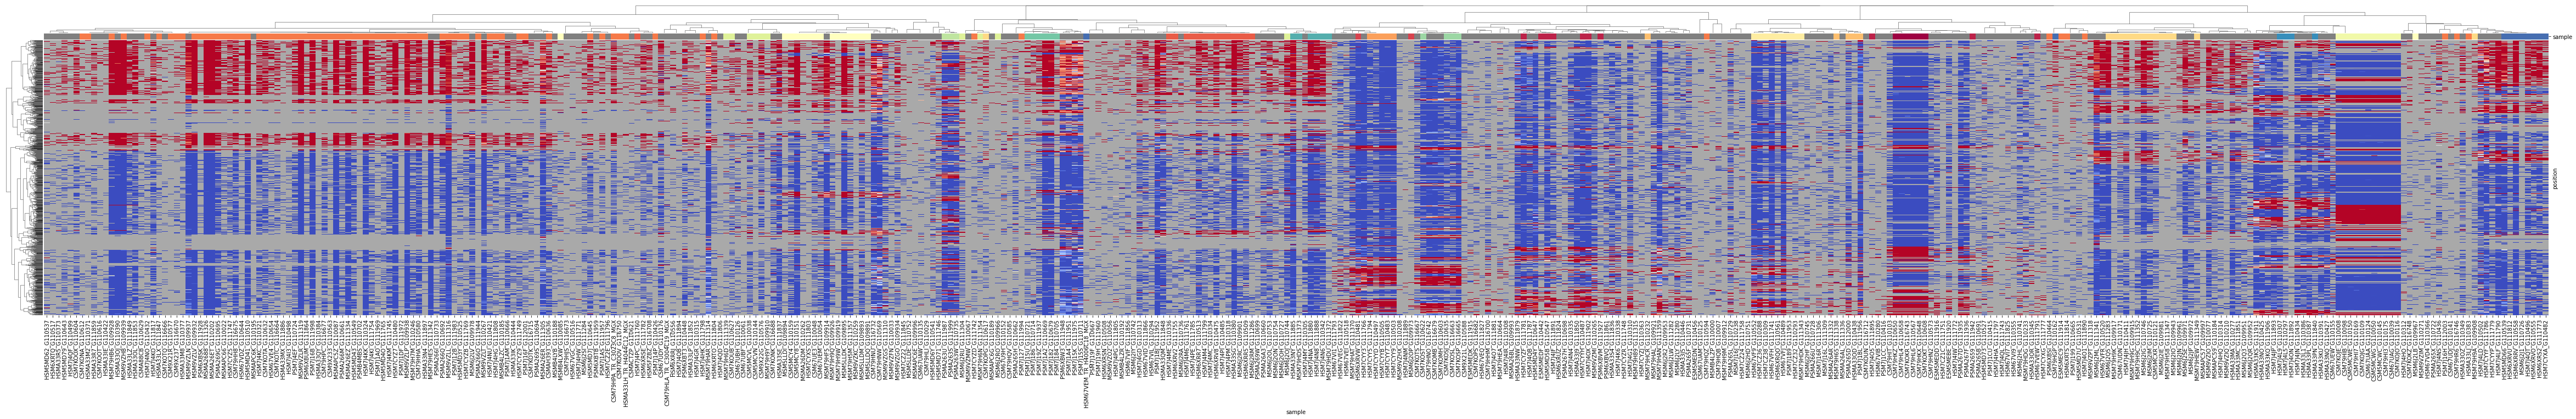

In [42]:
sf.plot.plot_metagenotype(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.metagenotype.linkage("position"),
    col_colors=fit.sel(sample=samples_with_high_power_strains, position=position_ss).sample.to_series().map(sample_to_strain).map(high_power_strain_palette),
)

/include/StrainFacts/sfacts/math.py:28: RuntimeWarning: invalid value encountered in float_scalars
  wmean_dist = (weight * dist).sum() / weight.sum()


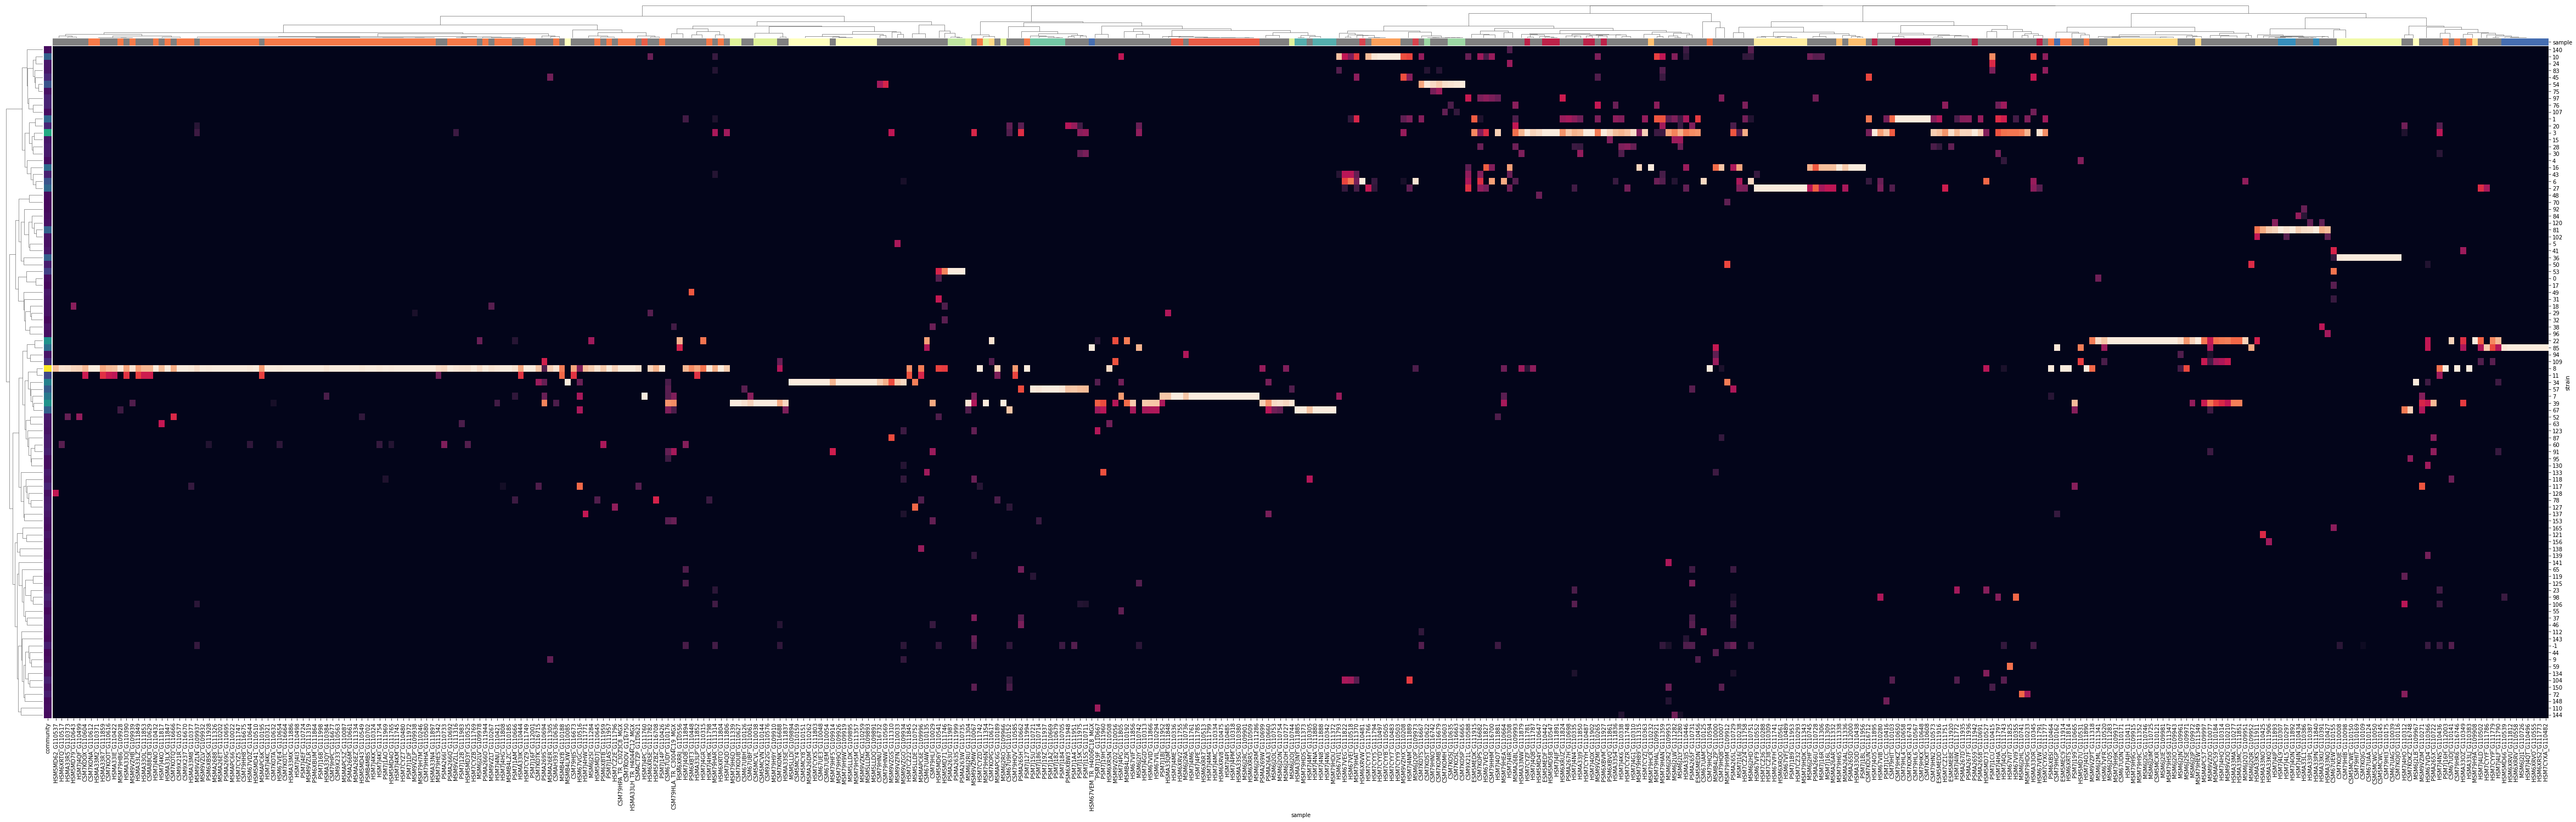

In [43]:
sf.plot.plot_community(
    fit.sel(sample=samples_with_high_power_strains, position=position_ss).drop_low_abundance_strains(0.05),
    col_linkage_func=lambda w: w.metagenotype.linkage(),
    row_linkage_func=lambda w: w.genotype.linkage("strain"),
    col_colors=fit.sel(sample=samples_with_high_power_strains, position=position_ss).sample.to_series().map(sample_to_strain).map(high_power_strain_palette),
)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


12771 4588

tRNA modification                              38
Fatty acid biosynthesis                        29
Glycolysis                                     29
Ribosome 50S subunit                           28
TCA cycle                                      26
Non-phosphorylated Entner-Doudoroff pathway    25
Aminoacyl-tRNA synthetases                     22
Isoprenoid biosynthesis                        19
Pyrimidine salvage                             18
Aromatic amino acid biosynthesis               18
Name: pathway, dtype: int64

hypothetical protein                           8183
Vitamin B12 import ATP-binding protein BtuD      47
Tyrosine recombinase XerC                        37
Prophage integrase IntA                          31
Prophage integrase IntS                          16
putative protein                                 13
LexA repressor                                   11
Sialic acid transporter NanT                     11
HTH-type transcriptional activator RhaR    

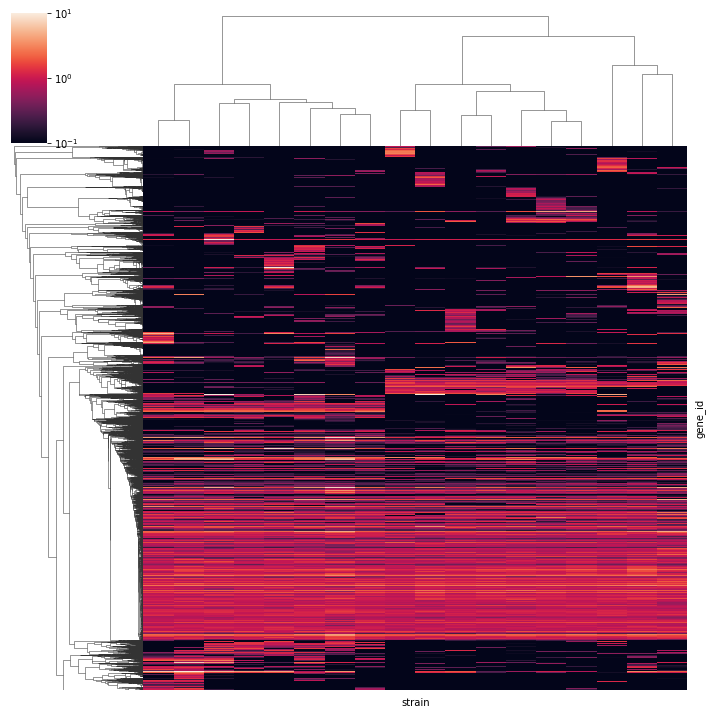

In [1087]:
strain_list = high_power_strain_list
gene_list = idxwhere(high_confidence_hit[strain_list].sum(1) > 0)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


3456 2214

tRNA modification                           32
Ribosome 50S subunit                        18
Fatty acid biosynthesis                     16
TCA cycle                                   15
Aminoacyl-tRNA synthetases                  13
Isoleucine, leucine, valine biosynthesis    13
16S rRNA modification                       12
Heme biosynthesis                           12
Menaquinone biosynthesis                    12
Aromatic amino acid biosynthesis            12
Name: pathway, dtype: int64

hypothetical protein                                             1242
Vitamin B12 import ATP-binding protein BtuD                        26
putative protein                                                    7
L-threonine 3-dehydrogenase                                         6
HTH-type transcriptional repressor NanR                             6
HTH-type transcriptional activator RhaS                             5
HTH-type transcriptional regulator HdfR                             5


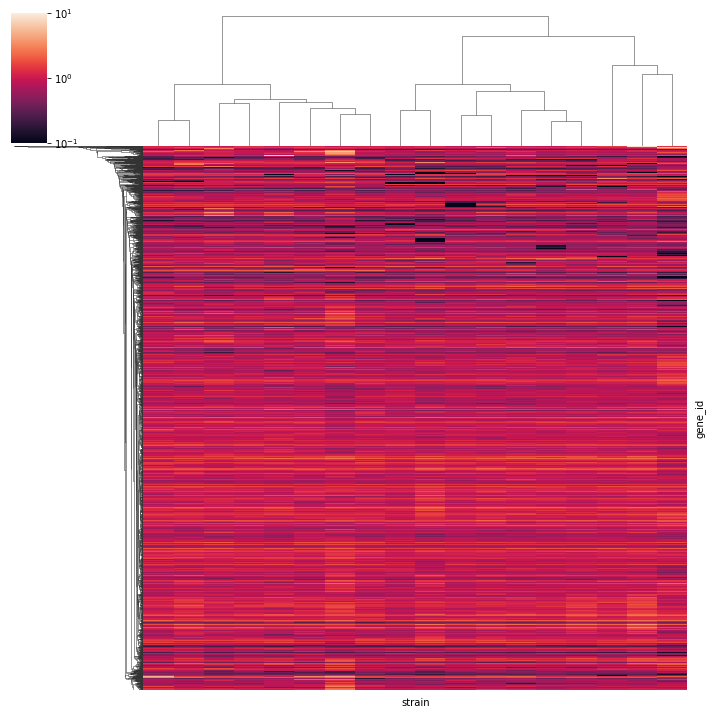

In [45]:
strain_list = high_power_strain_list
gene_list = idxwhere(high_confidence_hit[strain_list].mean(1) > 0.8)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


9443 2561

Fatty acid biosynthesis                        19
tRNA modification                              18
Non-phosphorylated Entner-Doudoroff pathway    16
Glycolysis                                     14
TCA cycle                                      12
Aromatic amino acid biosynthesis               11
Pyruvate oxidation                             10
Ribosome 50S subunit                           10
Isoleucine, leucine, valine biosynthesis       10
Ribosome 30S subunit                            9
Name: pathway, dtype: int64

hypothetical protein                           6882
Tyrosine recombinase XerC                        34
Prophage integrase IntA                          30
Prophage integrase IntS                          15
Vitamin B12 import ATP-binding protein BtuD      14
dTDP-4-dehydrorhamnose 3,5-epimerase             11
LexA repressor                                   10
putative protein YfcO                            10
putative protein                            

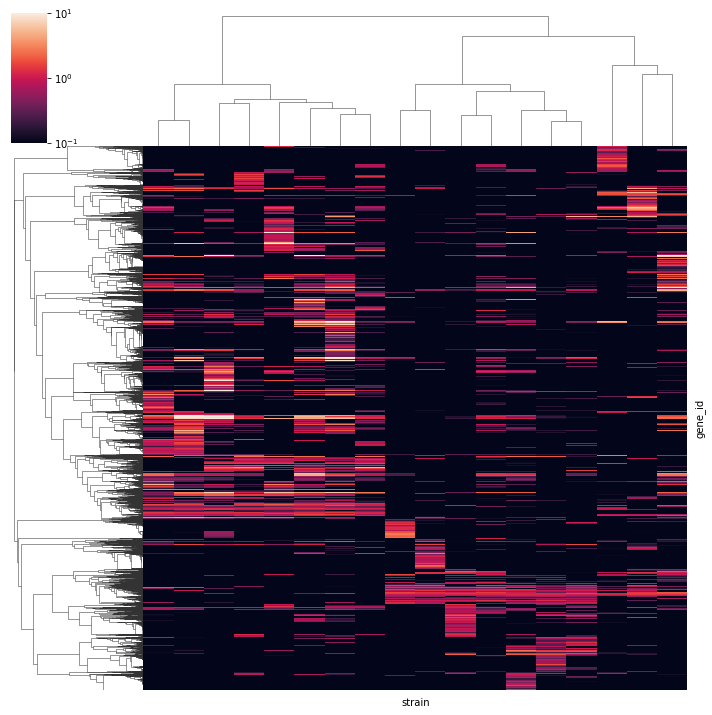

In [46]:
strain_list = high_power_strain_list
gene_list = idxwhere((high_confidence_hit[strain_list].mean(1) > 0.05) & (high_confidence_not_hit[strain_list].mean(1) > 0.2))

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

# Broad strokes characterization of gene sets

## Phylogenetic conservation

SpearmanrResult(correlation=0.6640431292134078, pvalue=8.285909205627315e-21)

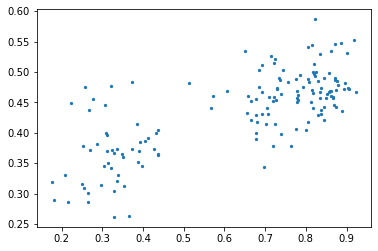

In [47]:
strain_list = high_power_strain_list
gene_list = high_confidence_hit.index

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = high_confidence_hit.loc[gene_list, strain_list]

fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)
gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

SpearmanrResult(correlation=0.868772867998874, pvalue=6.098326852686604e-48)

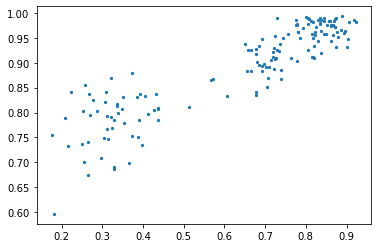

In [48]:
strain_list = high_power_strain_list
gene_list = idxwhere((high_confidence_hit[strain_list].mean(1) > 0.05) & (high_confidence_not_hit[strain_list].mean(1) > 0.2))

m = gene_meta.join(cog_meta, on='cog', rsuffix='_cog')
x = high_confidence_hit.loc[gene_list, strain_list]

fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)
gdist = fit.genotype.sel(strain=strain_list).pdist()

d = pd.DataFrame(dict(
    genotype_distance=sp.spatial.distance.squareform(gdist),
    gene_content_distance=sp.spatial.distance.squareform(fdist)
))
plt.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)

In [49]:
tally_cog_category_reps = pd.merge(
    gene_meta.loc[idxwhere(high_confidence_hit[strain_list].any(1))].cog.value_counts().reset_index().rename(columns=dict(index='cog', cog='tally')),
    cog_x_category,
    on='cog'
).groupby('category').tally.sum().sort_values(ascending=False)
tally_cog_category_reps

category
G    421
E    389
M    314
C    269
J    260
K    259
P    227
L    213
T    196
H    181
R    165
I    141
O    137
F    126
V    125
X     84
N     80
U     62
Q     55
D     49
W     46
S     41
Z      3
A      1
Name: tally, dtype: int64

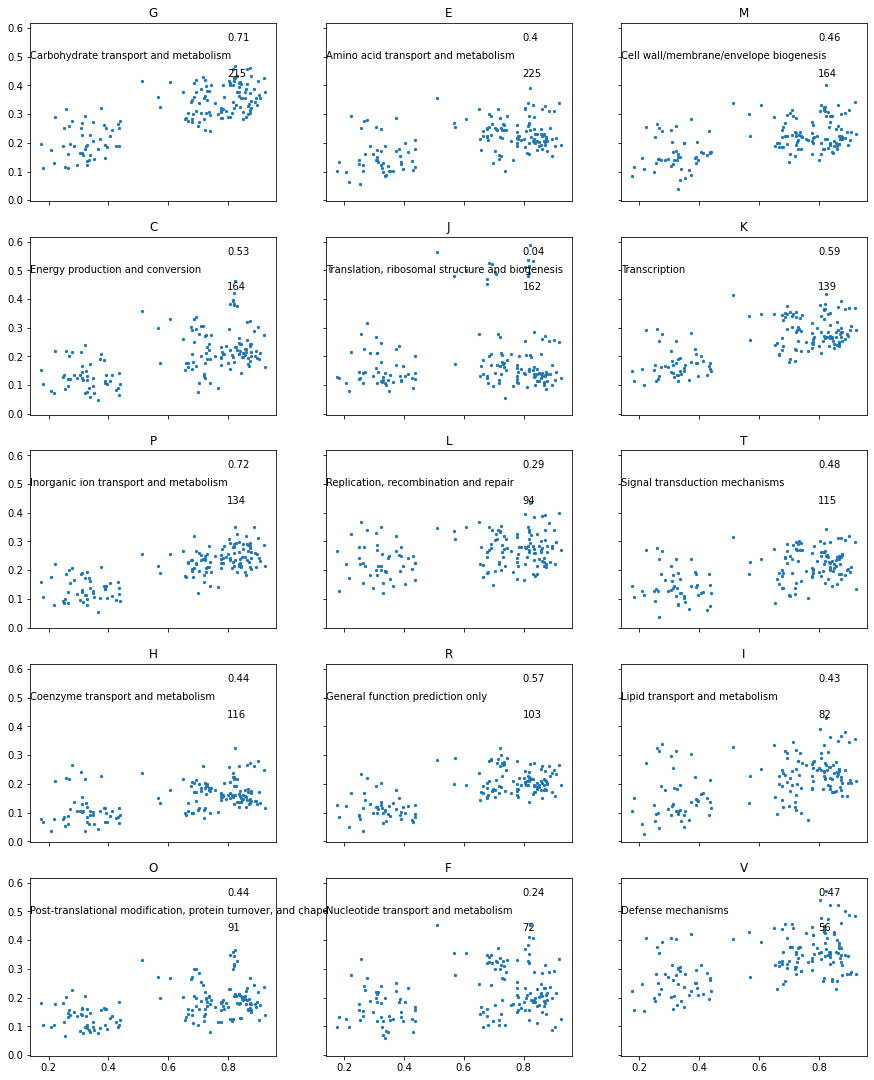

In [50]:
fig, axs = plt.subplots(5, 3, figsize=(15, 19), sharex=True, sharey=True)

for this_cog_category, ax in zip(tally_cog_category_reps.index, axs.flatten()):
    ax.set_title(this_cog_category)
    strain_list = high_power_strain_list
    cog_list = cog_x_category[cog_x_category.category == this_cog_category].cog.unique()
    gene_list = gene_meta.cog.isin(cog_list)

    x = high_confidence_hit.loc[gene_list, strain_list]
    fdist = pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(x.T, metric='jaccard')), index=x.columns, columns=x.columns)

    gdist = fit.genotype.sel(strain=strain_list).pdist()

    d = pd.DataFrame(dict(
        genotype_distance=sp.spatial.distance.squareform(gdist),
        gene_content_distance=sp.spatial.distance.squareform(fdist)
    ))
    ax.scatter('genotype_distance', 'gene_content_distance', data=d, s=5)
    ax.annotate(np.round(sp.stats.spearmanr(d.genotype_distance, d.gene_content_distance)[0], 2), xy=(0.8, 0.9), xycoords='axes fraction')
    ax.annotate(int(x.mean(1).sum()), xy=(0.8, 0.7), xycoords='axes fraction')
    ax.annotate(cog_category.loc[this_cog_category].description, xy=(0.0, 0.8), xycoords='axes fraction')

## Gene Clusters

In [70]:
from sklearn.cluster import OPTICS, AgglomerativeClustering, MiniBatchKMeans, KMeans, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [1088]:
strain_hit_gene_list = idxwhere((high_confidence_hit[high_power_strain_list].sum(1) > 0))
strain_hit_gene_list = idxwhere((reference_gene > 0).loc[strain_hit_gene_list].sum(1) > 2)

In [219]:
%%time
# Expect ~7 minutes
x = (reference_gene > 0).loc[strain_hit_gene_list]
clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, linkage='average', affinity='cosine').fit(x)

CPU times: user 6min 20s, sys: 1.04 s, total: 6min 21s
Wall time: 6min 21s


In [220]:
reference_gene_clust = pd.Series(clust.labels_, index=strain_hit_gene_list)

In [221]:
reference_gene_clust_list = idxwhere(reference_gene_clust.value_counts() > 1)

In [222]:
reference_gene_clust.value_counts()[reference_gene_clust_list]

4       2843
29        82
25        79
11        72
3253      56
        ... 
823        2
160        2
809        2
1632       2
391        2
Length: 844, dtype: int64

In [223]:
genes_in_reference_gene_clust_list = idxwhere(reference_gene_clust.isin(reference_gene_clust_list))

In [225]:
gene_clust_palette = lib.plot.construct_ordered_palette(reference_gene_clust_list)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


12771 4588

tRNA modification                              38
Fatty acid biosynthesis                        29
Glycolysis                                     29
Ribosome 50S subunit                           28
TCA cycle                                      26
Non-phosphorylated Entner-Doudoroff pathway    25
Aminoacyl-tRNA synthetases                     22
Isoprenoid biosynthesis                        19
Pyrimidine salvage                             18
Aromatic amino acid biosynthesis               18
Name: pathway, dtype: int64

hypothetical protein                           8183
Vitamin B12 import ATP-binding protein BtuD      47
Tyrosine recombinase XerC                        37
Prophage integrase IntA                          31
Prophage integrase IntS                          16
putative protein                                 13
LexA repressor                                   11
Sialic acid transporter NanT                     11
HTH-type transcriptional activator RhaR    

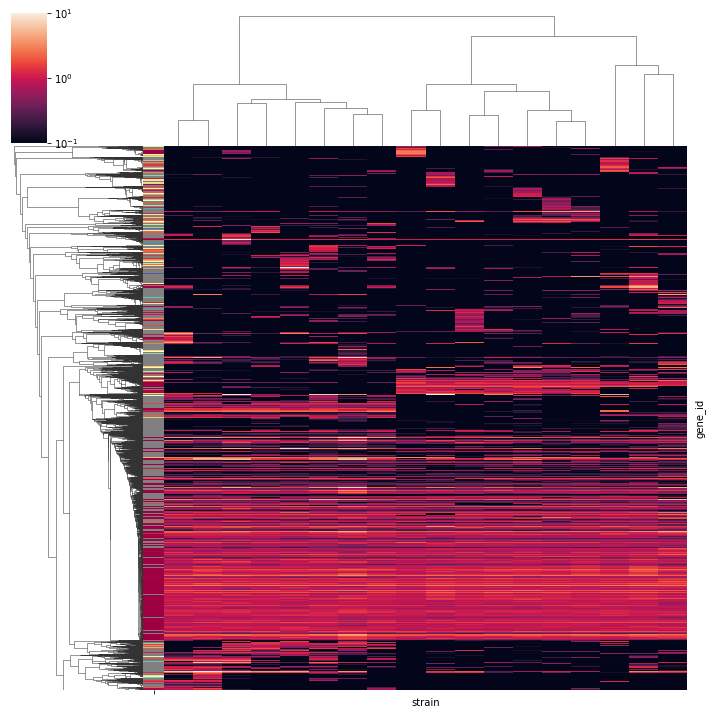

In [1092]:
strain_list = high_power_strain_list
gene_list = idxwhere(high_confidence_hit[high_power_strain_list].any(1))

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
        row_colors=reference_gene_clust.reindex(gene_list).map(gene_clust_palette),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


2843 2189

tRNA modification                           31
Ribosome 50S subunit                        25
Aminoacyl-tRNA synthetases                  17
TCA cycle                                   14
Fatty acid biosynthesis                     14
Glycolysis                                  13
Isoleucine, leucine, valine biosynthesis    13
23S rRNA modification                       12
Heme biosynthesis                           12
Aromatic amino acid biosynthesis            12
Name: pathway, dtype: int64

hypothetical protein                              654
Vitamin B12 import ATP-binding protein BtuD        35
putative protein                                    6
HTH-type transcriptional repressor NanR             5
p-hydroxybenzoic acid efflux pump subunit AaeA      4
HTH-type transcriptional activator RhaS             4
L-threonine 3-dehydrogenase                         4
Sialic acid transporter NanT                        4
HTH-type transcriptional regulator HdfR             4
Regu

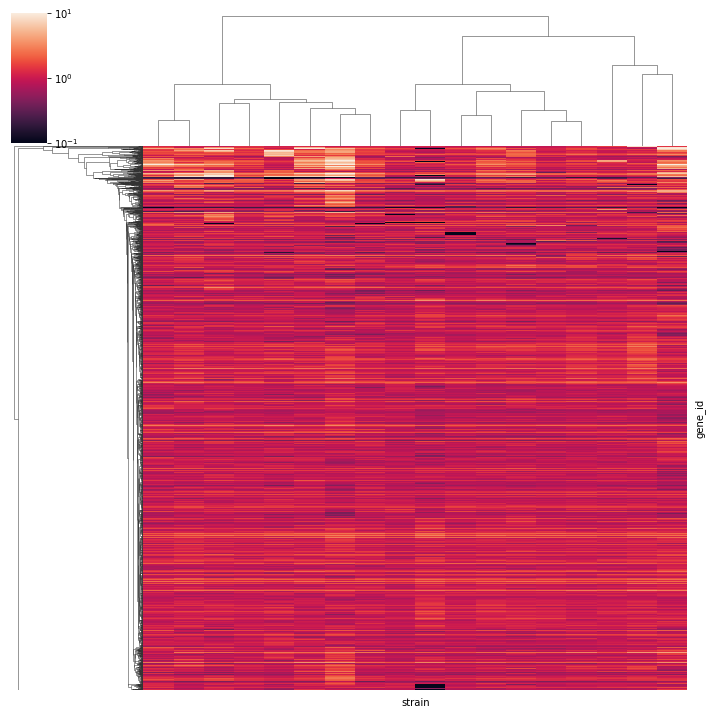

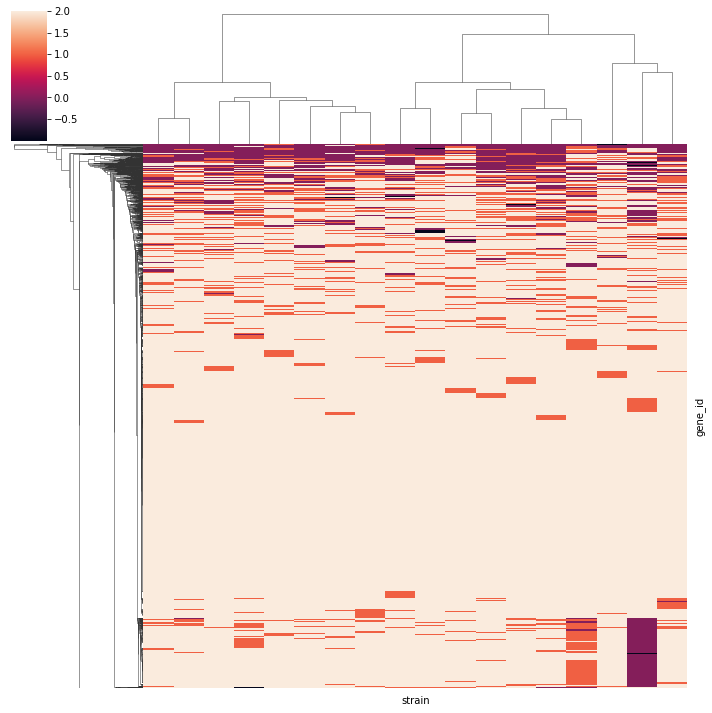

In [1120]:
strain_list = high_power_strain_list
gene_list = idxwhere(reference_gene_clust == reference_gene_clust_list[0])

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))
    
x2 = (high_confidence_hit.astype(int) + maybe_hit.astype(int) - high_confidence_not_hit.astype(int)).loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x2 + 1e-4,
        metric='cosine',
        # norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

82 11

Pyrimidine salvage          2
Thymidylate biosynthesis    1
Name: pathway, dtype: int64

hypothetical protein                                    71
Nucleoid occlusion protein                               1
DNA polymerase III subunit alpha                         1
Thymidylate synthase 2                                   1
Ribonucleoside-diphosphate reductase 1 subunit beta      1
Dihydrofolate reductase                                  1
Iron-sulfur cluster carrier protein                      1
Flap endonuclease Xni                                    1
Ribonucleoside-diphosphate reductase 1 subunit alpha     1
Chromosome partition protein Smc                         1
Name: product, dtype: int64

   category                                        description
F         3                Nucleotide transport and metabolism
L         1              Replication, recombination and repair
D         1  Cell cycle control, cell division, chromosome ...


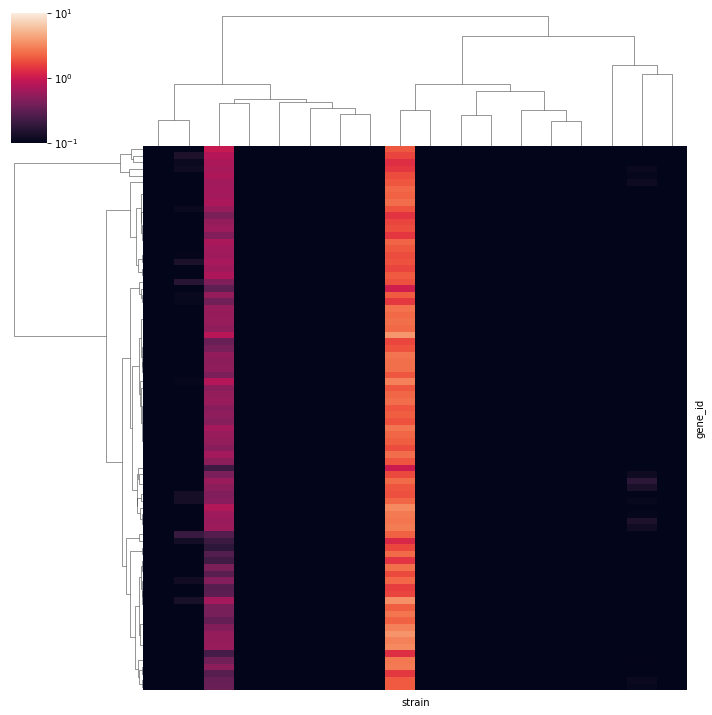

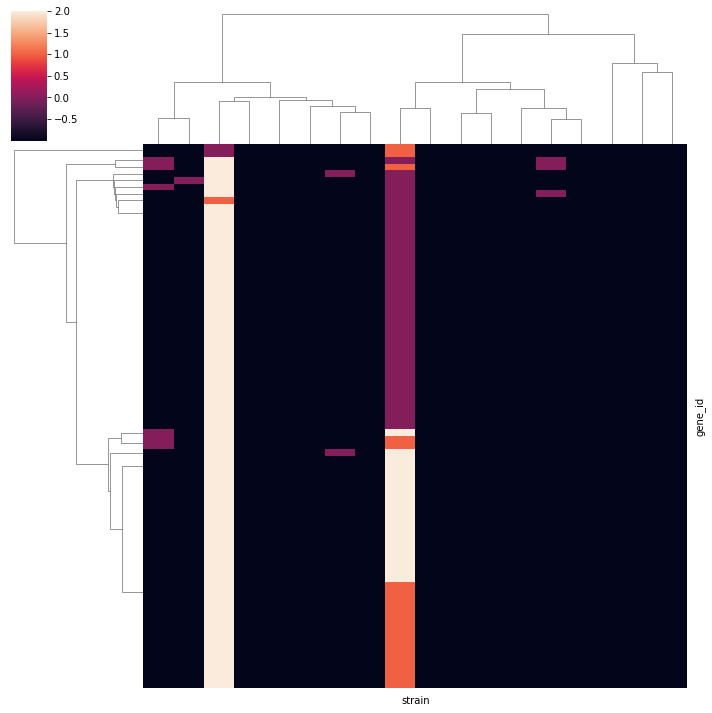

In [1121]:
strain_list = high_power_strain_list
gene_list = idxwhere(reference_gene_clust == reference_gene_clust_list[1])

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))
    
x2 = (high_confidence_hit.astype(int) + maybe_hit.astype(int) - high_confidence_not_hit.astype(int)).loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x2 + 1e-4,
        metric='cosine',
        # norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

79 60

TCA cycle                                      2
Methionine biosynthesis                        1
Proline degradation                            1
Non-phosphorylated Entner-Doudoroff pathway    1
Arginine biosynthesis                          1
Glycolysis                                     1
Pyrimidine salvage                             1
Pyrimidine biosynthesis                        1
Name: pathway, dtype: int64

hypothetical protein                               19
Valine--pyruvate aminotransferase                   1
L-ribulose-5-phosphate 3-epimerase UlaE             1
Periplasmic alpha-amylase                           1
Adenine deaminase                                   1
Allantoate amidohydrolase                           1
Cyclic di-GMP phosphodiesterase PdeL                1
D-xylose-binding periplasmic protein                1
Propionate catabolism operon regulatory protein     1
2-methylcitrate dehydratase                         1
Name: product, dtype: int64

   

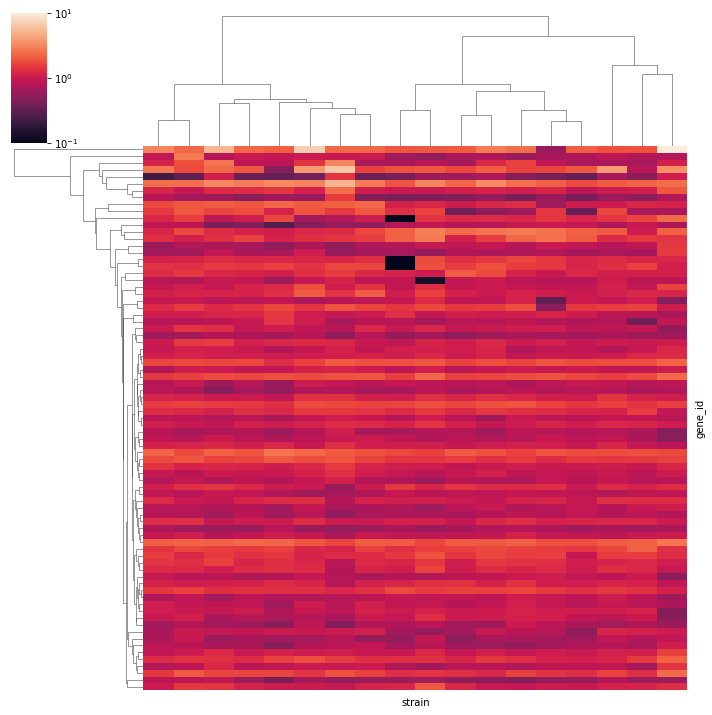

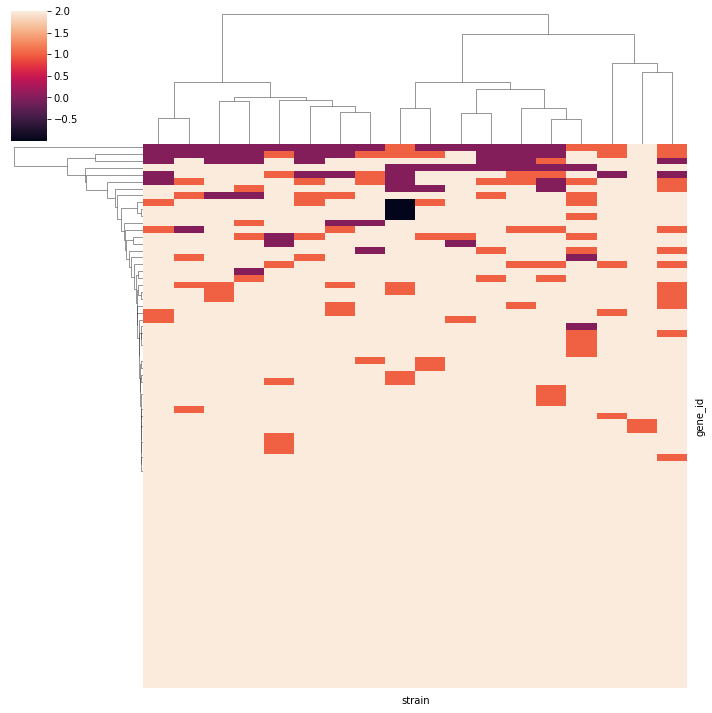

In [1122]:
strain_list = high_power_strain_list
gene_list = idxwhere(reference_gene_clust == reference_gene_clust_list[2])

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))
    
x2 = (high_confidence_hit.astype(int) + maybe_hit.astype(int) - high_confidence_not_hit.astype(int)).loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x2 + 1e-4,
        metric='cosine',
        # norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

In [1124]:
gene_clust_depth = gene_depth.to_series().unstack().groupby(reference_gene_clust).mean().rename(int).T
gene_clust_depth_trimmed_mean = gene_depth.to_series().unstack().groupby(reference_gene_clust).apply(lambda x: pd.Series(sp.stats.trim_mean(x, 0.2), index=x.columns)).rename(int).T

In [1125]:
species_with_cluster = (((gene_clust_depth_trimmed_mean.T / species_depth) > 0.1) & (species_depth > 1e-3)).T
species_with_cluster_sample_frac = species_with_cluster.groupby(sample_meta.subject_id).mean()

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


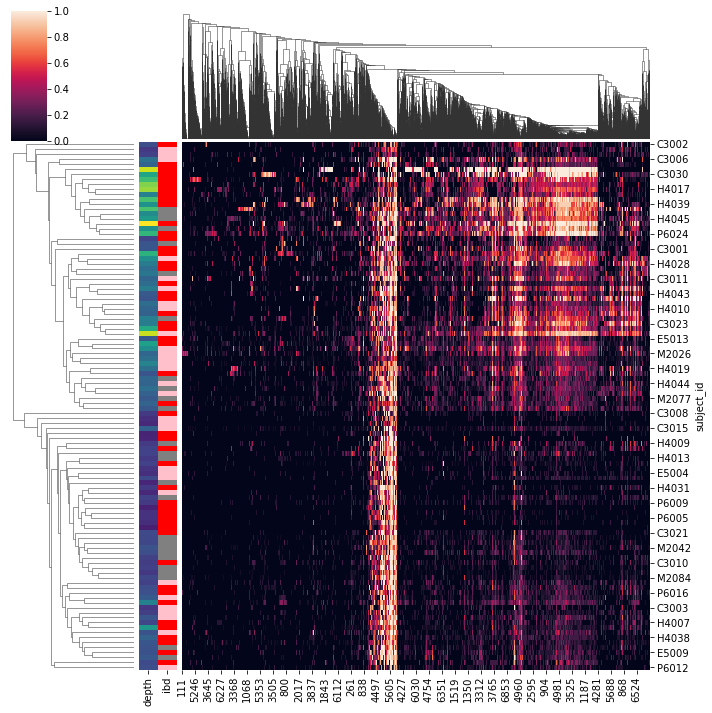

In [1126]:
depth = species_depth_by_subject
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[species_with_cluster_sample_frac.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    species_with_cluster_sample_frac,
    metric='cosine',
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
)

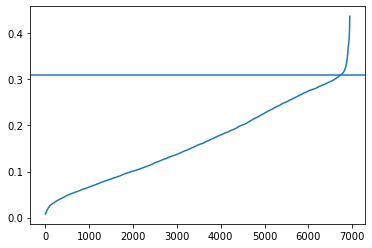

In [1127]:
plt.plot(species_with_cluster_sample_frac.std().sort_values().values)
plt.axhline(0.31)

In [1128]:
species_with_cluster_sample_frac.std().gt(0.2).sum()

2473

In [829]:
d0 = species_with_cluster_sample_frac
d1 = d0.loc[:, d0.std() > 0.2]
y = subject.ibd_diagnosis.isin(['UC', 'CD'])

gene_cluster_test = d1.apply(lambda x: sp.stats.mannwhitneyu(x[y], x[~y])).T[1].rename('pvalue')

In [830]:
from statsmodels.stats.multitest import fdrcorrection

fdr_gene_cluster_test = pd.Series(fdrcorrection(gene_cluster_test)[1], index=gene_cluster_test.index)

fdr_gene_cluster_test.sort_values().head(30)

2755    0.137267
1768    0.137267
3070    0.137267
5961    0.137267
1480    0.137267
1537    0.137267
6238    0.137267
1409    0.137267
5605    0.137267
5033    0.137267
2669    0.137529
147     0.137529
1018    0.139854
2166    0.139854
6525    0.182670
2255    0.197138
1398    0.197138
5555    0.197138
5965    0.197138
6532    0.197138
2849    0.197138
3419    0.227404
6611    0.284456
3793    0.292087
1889    0.292087
1802    0.304023
6397    0.323540
4001    0.357028
1167    0.357028
6761    0.363078
dtype: float64

<AxesSubplot:xlabel='clust_id', ylabel='frac'>

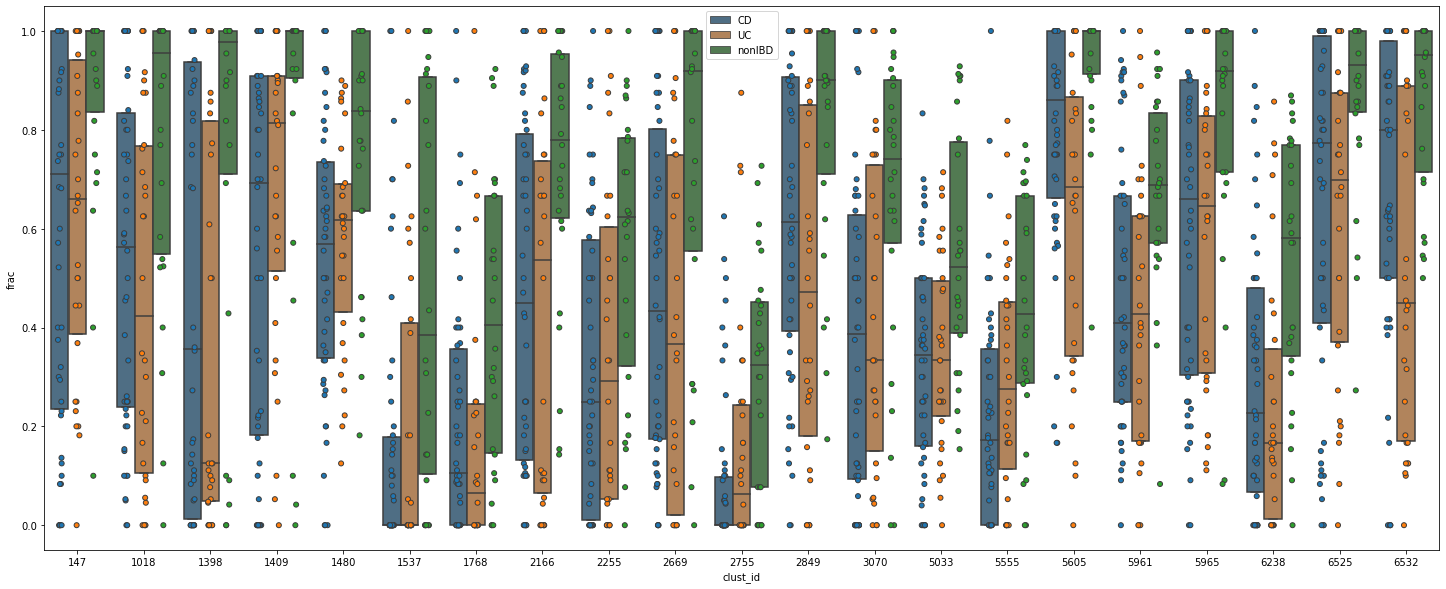

In [831]:
d0 = species_with_cluster_sample_frac
y = subject#.ibd_diagnosis.isin(['UC', 'CD'])

d1 = d0.rename_axis(columns='clust_id').unstack().to_frame('frac').reset_index().join(y, on='subject_id')

fig, ax = plt.subplots(figsize=(25, 10))
lib.plot.boxplot_with_points(
    'clust_id',
    'frac',
    hue='ibd_diagnosis',
    data=d1[d1.clust_id.isin(idxwhere(fdr_gene_cluster_test < 0.15))],
    dodge=True,
    ax=ax)

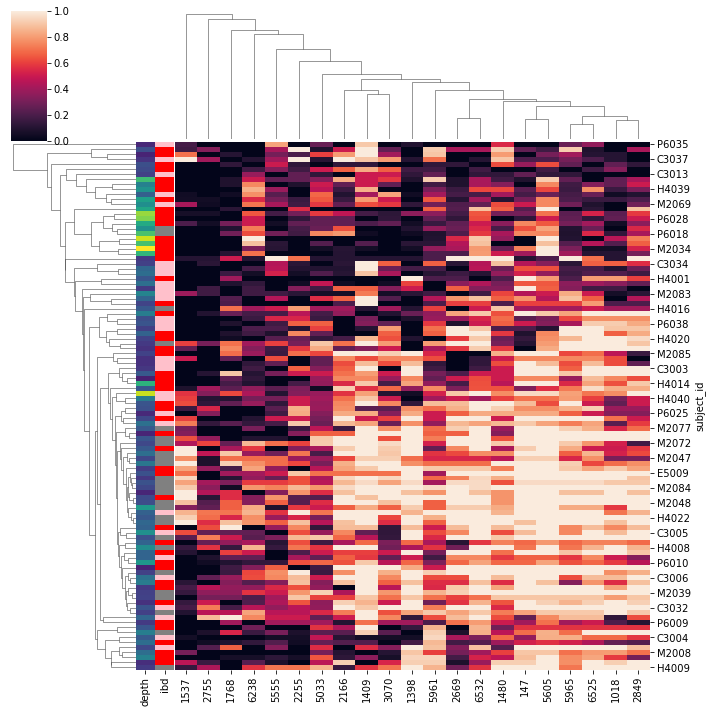

In [833]:
d = species_with_cluster_sample_frac[idxwhere(species_with_cluster_sample_frac.columns.to_series().isin(idxwhere(fdr_gene_cluster_test < 0.2)))]
depth = species_depth_by_subject
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[species_with_cluster_sample_frac.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    d,
    metric='cosine',
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
)

In [854]:
reference_gene_clust_list[0], reference_gene_clust_list[10], reference_gene_clust_list[2],

(4, 174, 25)

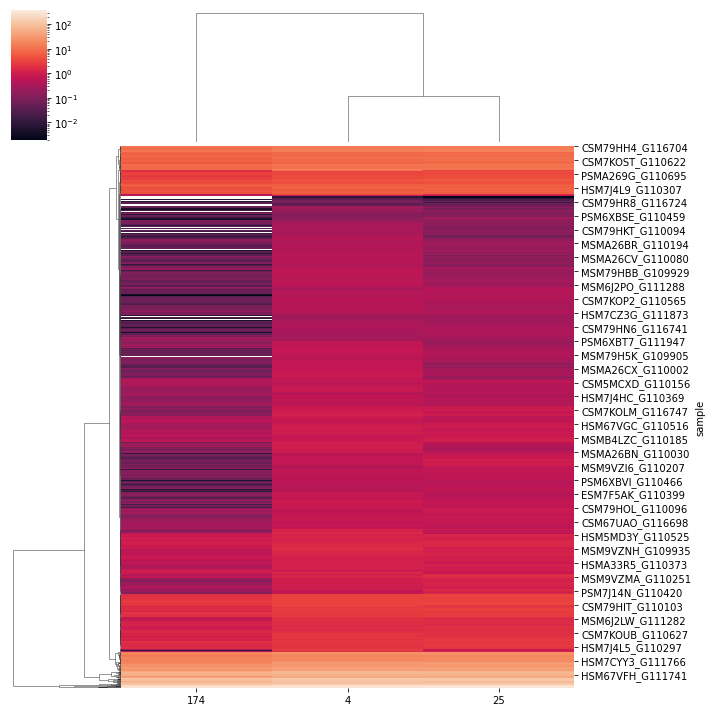

In [855]:
sns.clustermap(gene_clust_depth[[4, 174, 25]], norm=mpl.colors.LogNorm())

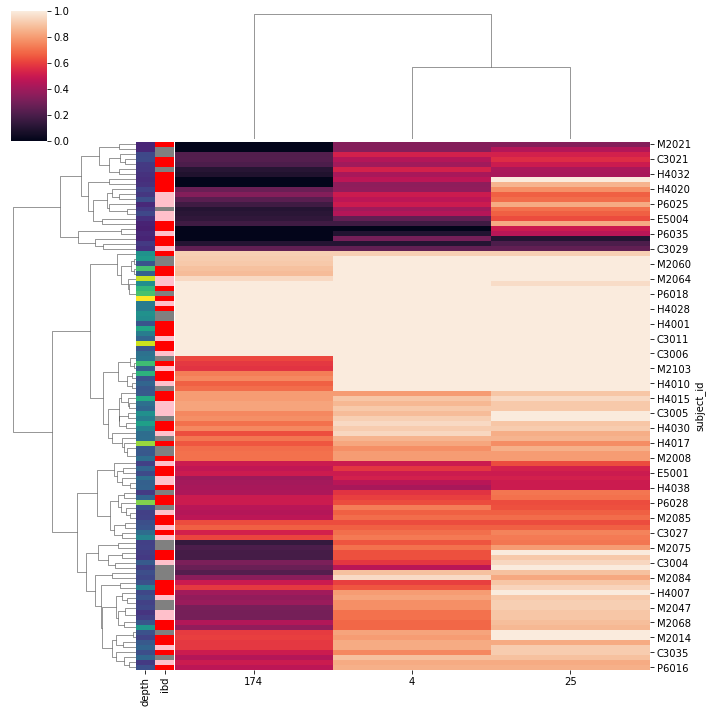

In [856]:
d = species_with_cluster_sample_frac[[4, 174, 25]]
depth = species_depth_by_subject
depth_colors = ((depth / depth.max())**(1/4)).map(mpl.cm.viridis)
diagnosis_colors = subject.loc[species_with_cluster_sample_frac.index].ibd_diagnosis.map({'CD': 'red', 'UC': 'pink', 'nonIBD': 'grey'})

sns.clustermap(
    d,
    # metric='cosine',
    row_colors=depth_colors.to_frame('depth').assign(ibd=diagnosis_colors),
)

In [819]:
reference_gene_clust[reference_gene_clust.isin(idxwhere(fdr_gene_cluster_test < 0.1))].value_counts()

147     2
5557    1
3510    1
2213    1
3669    1
2255    1
2430    1
1889    1
1409    1
2954    1
1929    1
2166    1
1802    1
1940    1
2849    1
1398    1
2447    1
2639    1
1018    1
3187    1
5965    1
6751    1
5040    1
3925    1
5583    1
6841    1
3868    1
6525    1
3793    1
4632    1
6761    1
5467    1
6532    1
6604    1
3331    1
2669    1
6235    1
3070    1
1537    1
dtype: int64

In [1077]:
gene_meta.loc[idxwhere(reference_gene_clust == 147)]

,centroid_99,centroid_95,centroid_90,centroid_85,centroid_80,centroid_75,centroid_99_length,marker_id,ftype,length_bp,gene,ec_number,cog,product
gene_id,,,,,,,,,,,,,,
UHGG176024_02600,UHGG176024_02600,UHGG176024_02600,UHGG176024_02600,UHGG176024_02600,UHGG176024_02600,UHGG176024_02600,1650,NaN,CDS,1650,NaN,NaN,NaN,hypothetical protein
UHGG146422_00293,UHGG146422_00293,UHGG146422_00293,UHGG146422_00293,UHGG146422_00293,UHGG146422_00293,UHGG146422_00293,1056,NaN,CDS,1056,psuK,2.7.1.83,COG0524,Pseudouridine kinase


2 1

Glycolysis    1
Name: pathway, dtype: int64

hypothetical protein    1
Pseudouridine kinase    1
Name: product, dtype: int64

   category                            description
G         1  Carbohydrate transport and metabolism


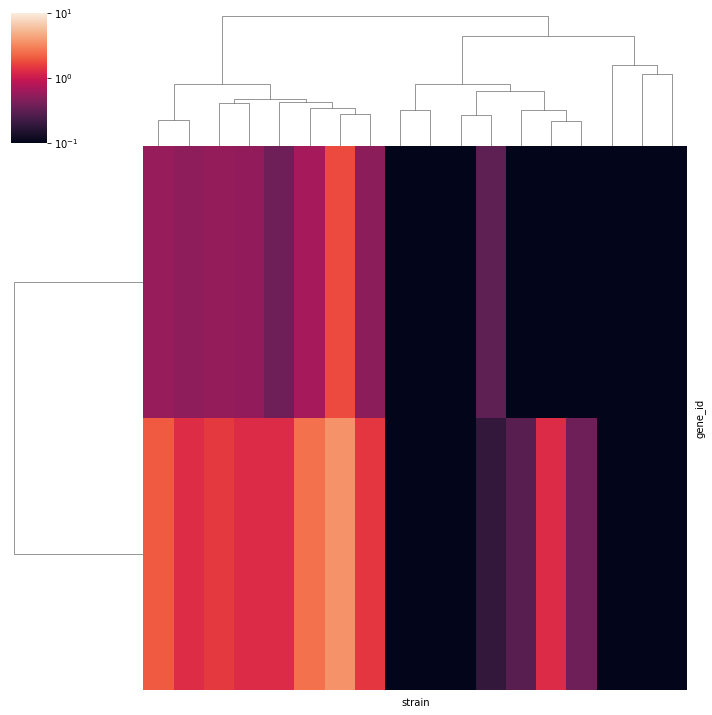

In [1075]:
strain_list = high_power_strain_list
gene_list = idxwhere(reference_gene_clust == 147)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

14 7

Fatty acid biosynthesis    2
Name: pathway, dtype: int64

hypothetical protein                                                  7
5'-deoxynucleotidase YfbR                                             1
Undecaprenyl-phosphate 4-deoxy-4-formamido-L-arabinose transferase    1
Acyl carrier protein                                                  1
1,4-dihydroxy-2-naphthoyl-CoA hydrolase                               1
3-oxoacyl-[acyl-carrier-protein] synthase 2                           1
L-tyrosine C(3)-methyltransferase                                     1
3-oxoacyl-[acyl-carrier-protein] reductase FabG                       1
Name: product, dtype: int64

   category                                        description
I         2                     Lipid transport and metabolism
Q         1  Secondary metabolites biosynthesis, transport,...


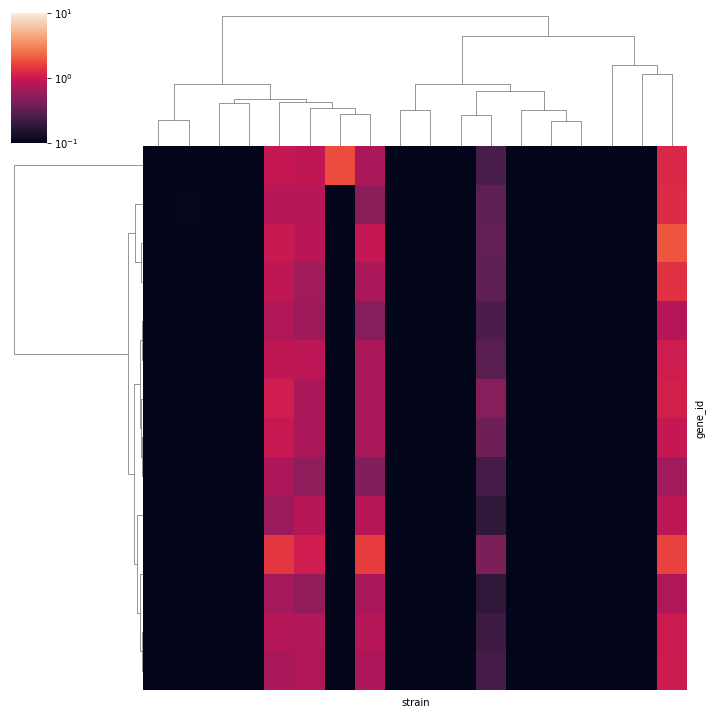

In [821]:
strain_list = high_power_strain_list
gene_list = idxwhere(reference_gene_clust == 602)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

2 1

Glycolysis    1
Name: pathway, dtype: int64

hypothetical protein    1
Pseudouridine kinase    1
Name: product, dtype: int64

   category                            description
G         1  Carbohydrate transport and metabolism


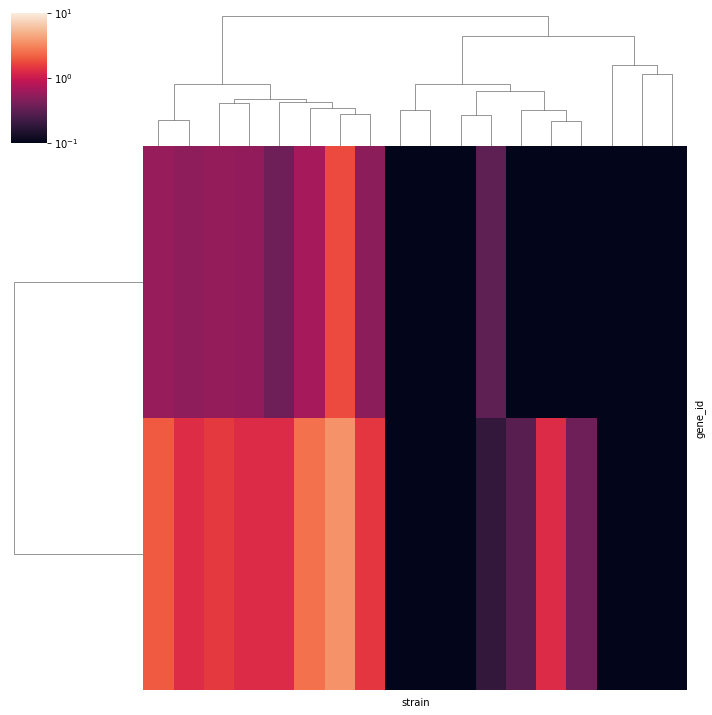

In [719]:
strain_list = high_power_strain_list
gene_list = idxwhere(reference_gene_clust == 147)

x = strain_depth.loc[gene_list, strain_list]

if len(gene_list) < 2e4:
    sns.clustermap(
        x,
        metric='cosine',
        norm=mpl.colors.SymLogNorm(linthresh=1e-4, vmin=0.1, vmax=10),
        yticklabels=0,
        xticklabels=0,
        col_linkage=fit.genotype.sel(strain=strain_list).linkage("strain"),
    )
else:
    print("Too many genes for clustermap:", len(gene_list))

print(len(gene_list), len(gene_list) - gene_annotation.loc[gene_list]['product'].value_counts()['hypothetical protein'])
print()
print(
    gene_annotation
    .loc[gene_list]
    .cog.to_frame()
    .join(cog_meta, on='cog')
    .pathway
    .value_counts()
    .sort_values(ascending=False)
    .head(10)
)
print()
print(
    gene_meta
    .loc[gene_list]
    ['product']
    .value_counts()
    .head(10)
)
print()
print(pd.merge(
    gene_annotation.loc[gene_list].cog.dropna().to_frame(),
    cog_x_category,
    on='cog',
).category.value_counts().to_frame().join(cog_category).head(10))

(array([108.,  30.,  28.,  16.,  18.,  20.,  21.,  38.,  44., 301.]),
 array([5.135785e-11, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

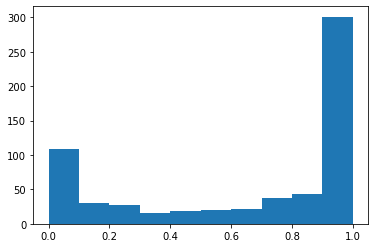

In [1129]:
plt.hist(fit.community.sel(strain=high_power_strain_list).sum("strain"))

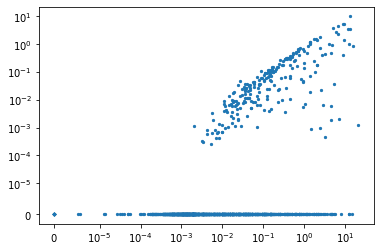

In [1130]:
x = species_depth / (sample_meta.sequenced_reads / 1e6)
y = gene_clust_depth_trimmed_mean[496] / (sample_meta.sequenced_reads / 1e6)

plt.scatter(x, y, s=5)
plt.yscale('symlog', linthresh=1e-5)
plt.xscale('symlog', linthresh=1e-5)

/pollard/home/bsmith/.snakemake/conda/204b2d5e194d4cedcf565e20990467c9/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


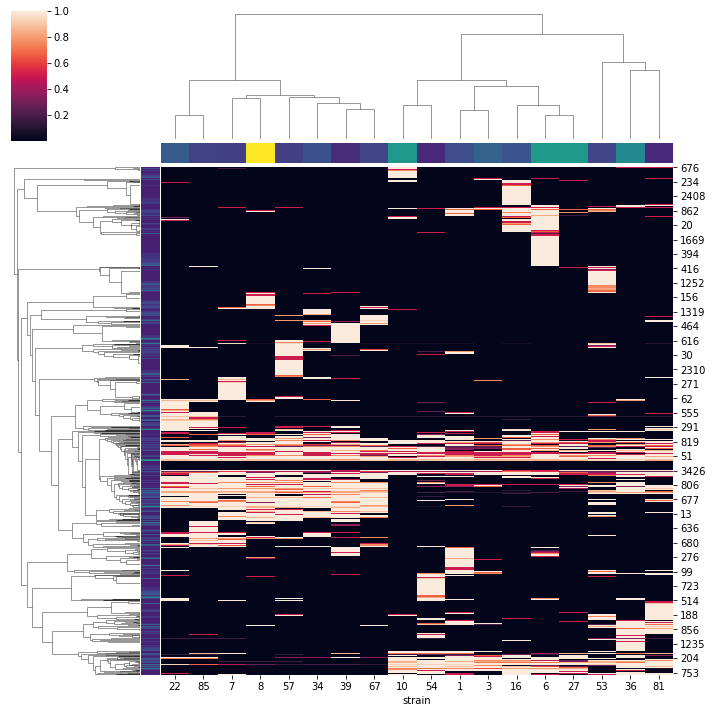

In [1133]:
d = high_confidence_hit[high_power_strain_list].groupby(reference_gene_clust).mean().rename(int).loc[reference_gene_clust_list]

sns.clustermap(
    d + 1e-4,
    metric='cosine',
    col_linkage=fit.genotype.sel(strain=d.columns).linkage(),
    col_colors=strain_meta.loc[d.columns].power_index.pipe(lambda x: x / x.max()).pipe(mpl.cm.viridis),
    row_colors=reference_gene_clust.value_counts().loc[reference_gene_clust_list].pipe(np.log10).pipe(lambda x: x / x.max()).pipe(mpl.cm.viridis),
    # figsize=(5, 50),
)

In [1136]:
high_confidence_hit[high_power_strain_list].groupby(reference_gene_clust).mean().rename(int).assign(clust_size=reference_gene_clust.value_counts()).sort_values('clust_size', ascending=False).head(10)

strain,1,3,6,7,8,10,16,22,27,34,36,39,53,54,57,67,81,85,clust_size
4,0.888498,0.850862,0.810412,0.852269,0.818853,0.854731,0.835737,0.848048,0.740767,0.852972,0.720366,0.864580,0.876187,0.881815,0.870208,0.880760,0.845234,0.848048,2843
29,0.000000,0.000000,0.000000,0.963415,0.000000,0.256098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82
25,0.936709,0.898734,0.835443,0.911392,0.886076,0.835443,0.886076,0.886076,0.822785,0.886076,0.974684,0.886076,0.924051,0.898734,0.873418,0.911392,0.810127,0.898734,79
11,0.902778,0.833333,0.902778,0.069444,0.041667,0.875000,0.861111,0.041667,0.763889,0.055556,0.861111,0.069444,0.875000,0.875000,0.055556,0.069444,0.875000,0.055556,72
3253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.839286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56
91,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.589744,0.000000,0.871795,0.000000,0.000000,0.000000,39
69,0.027027,0.000000,0.000000,0.918919,0.864865,0.000000,0.135135,0.972973,0.000000,0.945946,0.000000,0.945946,0.000000,0.054054,0.972973,0.864865,0.000000,0.945946,37
1565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.916667,0.000000,0.000000,0.000000,0.000000,0.000000,36
496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.971429,1.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.885714,0.000000,0.914286,0.000000,35
1028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.821429,0.000000,0.000000,0.000000,0.000000,28


In [1139]:
maybe_hit[high_power_strain_list].groupby(reference_gene_clust).mean().rename(int).assign(clust_size=reference_gene_clust.value_counts()).sort_values('clust_size', ascending=False).head(10)

strain,1,3,6,7,8,10,16,22,27,34,36,39,53,54,57,67,81,85,clust_size
4,0.968343,0.934928,0.928597,0.931410,0.937742,0.937038,0.936335,0.942314,0.948998,0.930707,0.803377,0.938445,0.956032,0.957439,0.948646,0.959198,0.942666,0.940204,2843
29,0.000000,0.000000,0.000000,0.975610,0.000000,0.512195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82
25,0.962025,0.949367,0.936709,0.949367,0.936709,0.911392,0.949367,0.936709,0.962025,0.949367,1.000000,0.949367,0.987342,0.962025,0.962025,0.962025,0.974684,0.962025,79
11,0.972222,0.972222,0.930556,0.111111,0.097222,0.944444,0.958333,0.097222,0.902778,0.097222,0.930556,0.194444,0.916667,0.986111,0.125000,0.097222,0.902778,0.125000,72
3253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56
91,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.589744,0.000000,0.897436,0.000000,0.000000,0.000000,39
69,0.027027,0.000000,0.000000,0.972973,0.918919,0.000000,0.162162,0.972973,0.000000,0.972973,0.000000,0.945946,0.000000,0.054054,1.000000,0.972973,0.000000,0.945946,37
1565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.971429,0.000000,35
1028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,28


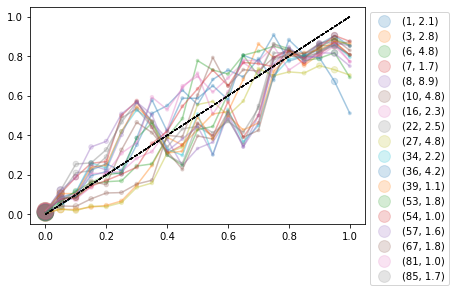

In [1140]:
# strain_id = 8
gene_freq = (reference_gene > 0).mean(1).sort_values()
# strain_content = high_confidence_hit[strain_id]

window_size = 0.01

def window_agg(df, by, width):
    df = df.assign(__window_idx=(df[by] / width).round())
    return df.groupby('__window_idx').agg(['mean', 'count']).rename(lambda x: x * width).rename_axis(index=by)
    
for strain_id in high_power_strain_list:
    d = (
        window_agg(
            pd.DataFrame(dict(strain_content=high_confidence_hit[strain_id].astype(float).reindex(gene_freq.index, fill_value=0), gene_freq=gene_freq)),
            by='gene_freq',
            width=0.05
        )
        .strain_content
        .reset_index()
        .assign(delta=lambda d: d['gene_freq'] - d['mean'])
        .assign(sqrt_count=lambda x: np.sqrt(x['count']))
    )
    plt.plot('gene_freq', 'mean', data=d, alpha=0.4, label='__none__')
    plt.scatter('gene_freq', 'mean', data=d, s='sqrt_count', linewidths=1, alpha=0.2, label=(strain_id, round(strain_meta.power_index[strain_id], 1)))
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='k')
plt.legend(bbox_to_anchor=(1, 1))

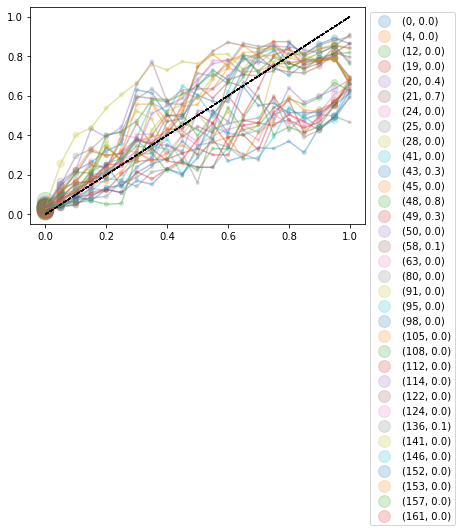

In [1141]:
# strain_id = 8
gene_freq = (reference_gene > 0).mean(1).sort_values()
# strain_content = high_confidence_hit[strain_id]

window_size = 0.01

def window_agg(df, by, width):
    df = df.assign(__window_idx=(df[by] / width).round())
    return df.groupby('__window_idx').agg(['mean', 'count']).rename(lambda x: x * width).rename_axis(index=by)
    
for strain_id in idxwhere(strain_meta.power_index < 1):
    d = (
        window_agg(
            pd.DataFrame(dict(strain_content=high_confidence_hit[strain_id].astype(float).reindex(gene_freq.index, fill_value=0), gene_freq=gene_freq)),
            by='gene_freq',
            width=0.05
        )
        .strain_content
        .reset_index()
        .assign(delta=lambda d: d['gene_freq'] - d['mean'])
        .assign(sqrt_count=lambda x: np.sqrt(x['count']))
    )
    plt.plot('gene_freq', 'mean', data=d, alpha=0.4, label='__none__')
    plt.scatter('gene_freq', 'mean', data=d, s='sqrt_count', linewidths=1, alpha=0.2, label=(strain_id, round(strain_meta.power_index[strain_id], 1)))
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='k')
plt.legend(bbox_to_anchor=(1, 1))

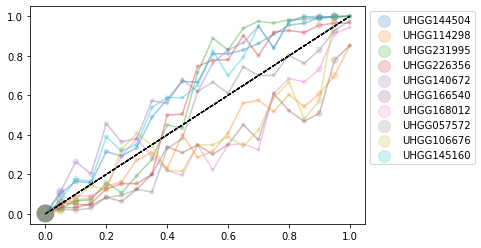

In [1142]:
# strain_id = 8
gene_freq = (reference_gene > 0).mean(1).sort_values()
# strain_content = high_confidence_hit[strain_id]

window_size = 0.01

def window_agg(df, by, width):
    df = df.assign(__window_idx=(df[by] / width).round())
    return df.groupby('__window_idx').agg(['mean', 'count']).rename(lambda x: x * width).rename_axis(index=by)
    
for strain_id in reference_gene.columns.to_series().sample(10):
    d = (
        window_agg(
            pd.DataFrame(dict(strain_content=(reference_gene > 0)[strain_id].astype(float).reindex(gene_freq.index, fill_value=0), gene_freq=gene_freq)),
            by='gene_freq',
            width=0.05
        )
        .strain_content
        .reset_index()
        .assign(delta=lambda d: d['gene_freq'] - d['mean'])
        .assign(sqrt_count=lambda x: np.sqrt(x['count']))
    )
    plt.plot('gene_freq', 'mean', data=d, alpha=0.4, label='__none__')
    plt.scatter('gene_freq', 'mean', data=d, s='sqrt_count', linewidths=1, alpha=0.2, label=strain_id)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='k')
plt.legend(bbox_to_anchor=(1, 1))

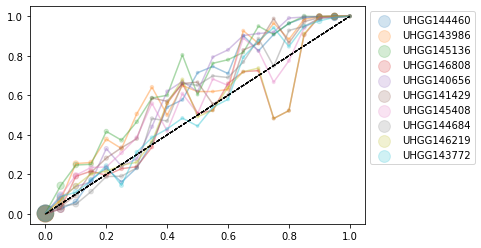

In [ ]:
# strain_id = 8
gene_freq = (reference_gene > 0).mean(1).sort_values()
# strain_content = high_confidence_hit[strain_id]

window_size = 0.01

def window_agg(df, by, width):
    df = df.assign(__window_idx=(df[by] / width).round())
    return df.groupby('__window_idx').agg(['mean', 'count']).rename(lambda x: x * width).rename_axis(index=by)
    
for strain_id in isolate_gene.columns.to_series().sample(10):
    d = (
        window_agg(
            pd.DataFrame(dict(strain_content=(reference_gene > 0)[strain_id].astype(float).reindex(gene_freq.index, fill_value=0), gene_freq=gene_freq)),
            by='gene_freq',
            width=0.05
        )
        .strain_content
        .reset_index()
        .assign(delta=lambda d: d['gene_freq'] - d['mean'])
        .assign(sqrt_count=lambda x: np.sqrt(x['count']))
    )
    plt.plot('gene_freq', 'mean', data=d, alpha=0.4, label='__none__')
    plt.scatter('gene_freq', 'mean', data=d, s='sqrt_count', linewidths=1, alpha=0.2, label=strain_id)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='k')
plt.legend(bbox_to_anchor=(1, 1))